<a href="https://colab.research.google.com/github/AilingLiu/Growth_Analysis/blob/master/Marketing_Analytics_Predicting_Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [56]:
data_url = 'https://raw.githubusercontent.com/AilingLiu/Growth_Analysis/master/Data/Churn.csv'
telco = pd.read_csv(data_url)
telco.head(3)

,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Churn,Intl_Plan,Vmail_Plan,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,State,Area_Code,Phone
0,128,25,265.1,197.4,244.7,10.0,1,no,no,yes,110,45.07,99,16.78,91,11.01,3,2.70,KS,415,382-4657
1,107,26,161.6,195.5,254.4,13.7,1,no,no,yes,123,27.47,103,16.62,103,11.45,3,3.70,OH,415,371-7191
2,137,0,243.4,121.2,162.6,12.2,0,no,no,no,114,41.38,110,10.30,104,7.32,5,3.29,NJ,415,358-1921


In [6]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account_Length  3333 non-null   int64  
 1   Vmail_Message   3333 non-null   int64  
 2   Day_Mins        3333 non-null   float64
 3   Eve_Mins        3333 non-null   float64
 4   Night_Mins      3333 non-null   float64
 5   Intl_Mins       3333 non-null   float64
 6   CustServ_Calls  3333 non-null   int64  
 7   Churn           3333 non-null   object 
 8   Intl_Plan       3333 non-null   object 
 9   Vmail_Plan      3333 non-null   object 
 10  Day_Calls       3333 non-null   int64  
 11  Day_Charge      3333 non-null   float64
 12  Eve_Calls       3333 non-null   int64  
 13  Eve_Charge      3333 non-null   float64
 14  Night_Calls     3333 non-null   int64  
 15  Night_Charge    3333 non-null   float64
 16  Intl_Calls      3333 non-null   int64  
 17  Intl_Charge     3333 non-null   f

# Exploratory Data Analysis

###How many people churned, and not churned?

In [7]:
telco['Churn'].value_counts()

no     2850
yes     483
Name: Churn, dtype: int64

In [10]:
telco.groupby(['Churn'])[['CustServ_Calls', 'Vmail_Message']].mean()

,CustServ_Calls,Vmail_Message
Churn,,
no,1.449825,8.604561
yes,2.229814,5.115942


Churners make more customer service calls than non-churners.

### Churn By State

Top 10 states with the highest number of churned customer

In [36]:
telco.groupby('State')['Churn'].value_counts().to_frame('numChurn').loc[(slice(None), ['yes']), :].sort_values(by='numChurn', ascending=False).head(10)

,,numChurn
State,Churn,
NJ,yes,18
TX,yes,18
MD,yes,17
MI,yes,16
MN,yes,15
NY,yes,15
MT,yes,14
NV,yes,14
MS,yes,14


### Visualize distribution on features


* 'Day_Mins'
* 'Eve_Mins'
* 'Night_Mins'
* 'Intl_Mins'




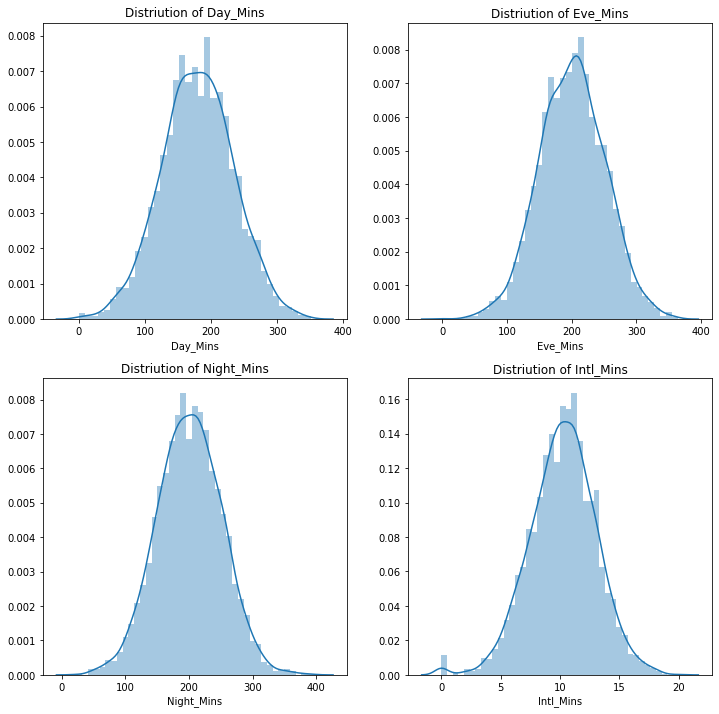

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

features = ['Day_Mins',
'Eve_Mins',
'Night_Mins',
'Intl_Mins']

for i, feat in enumerate(features):
  if i < 2:
    sns.distplot(telco[feat], ax=axes[0, i])
    axes[0, i].set(title='Distriution of ' + feat)
  else:
    sns.distplot(telco[feat], ax=axes[1, i-2])
    axes[1, i-2].set(title='Distriution of ' + feat)

plt.show()

All of these features appear to be well approximated by the normal distribution. If this were not the case, we would have to consider applying a feature transformation of some kind.

### Customer service calls and churn

Do customers who have international plans make more customer service calls? Or do they tend to churn more?

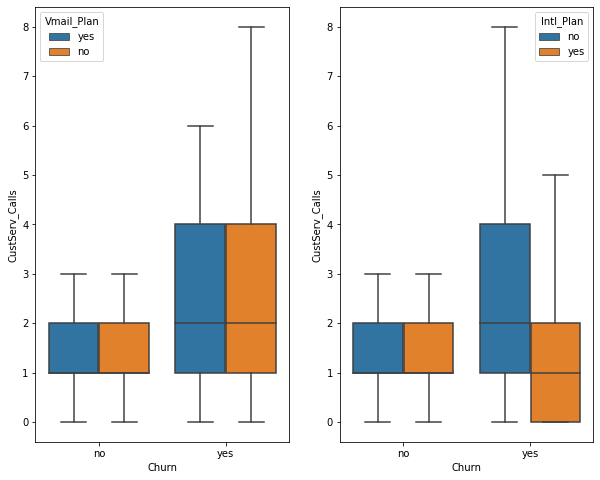

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))


sns.boxplot(x = 'Churn',
            y = 'CustServ_Calls',
            data = telco,
            sym = "",#remove outlier
            hue = "Vmail_Plan", ax=ax1)


sns.boxplot(x = 'Churn',
            y = 'CustServ_Calls',
            data = telco,
            sym = "",
            hue = "Intl_Plan", ax=ax2)
plt.show()

It looks like customers who do churn end up leaving more customer service calls, unless these customers also have an international plan, in which case they leave fewer customer service calls.

# Data Preprocessing


- assumptions of the data need to be met to make the model effective:

 * normally distributed
 * similar scale

- other preprocessing:

 * encode categorical features (label encode for binary feature, and one hot encode for multi level feature)


### *encoding*

In [57]:
cat_features = telco.select_dtypes('object').columns.tolist()
cat_features

['Churn', 'Intl_Plan', 'Vmail_Plan', 'State', 'Phone']

In [58]:
binary_features = telco[cat_features].nunique()[np.where(telco[cat_features].nunique()==2)[0]].index.values.tolist()
binary_features

['Churn', 'Intl_Plan', 'Vmail_Plan']

In [0]:
replaced_vals = {'yes': 1, 'no': 0}

for col in binary_features:
  telco[col] = telco[col].replace(replaced_vals)

In [60]:
# Perform one hot encoding on 'State'
telco_state = pd.get_dummies(telco['State'])
telco_state.head(3)

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### *Feature selection and feature engineering*


* get rid of the features that doen't provide predictive power, such as phone number, account identifier
* engineer features according to business knowledge, such as adding new features based on existed features, etc.

This quote from Andrew Ng summarizes the importance of feature engineering:

> Coming up with features is difficult, time-consuming, requires expert knowledge. "Applied machine learning" is basically feature engineering.

In [66]:
drop_feats = ['Area_Code','Phone']
telco = telco.drop(drop_feats, axis=1)
telco.columns

Index(['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 'Night_Mins',
       'Intl_Mins', 'CustServ_Calls', 'Churn', 'Intl_Plan', 'Vmail_Plan',
       'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
       'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State'],
      dtype='object')

Create a new feature - 'Avg_Night_Calls' - that is the result of dividing 'Night_Mins by 'Night_Calls'.

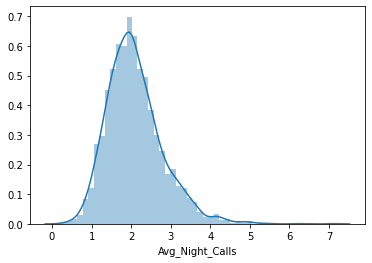

In [67]:
# Create the new feature
telco['Avg_Night_Calls'] = telco['Night_Mins'] / telco['Night_Calls']
sns.distplot(telco['Avg_Night_Calls'])

### *Scaling*

In [61]:
unscaled_feat = ['Intl_Calls', 'Night_Mins']
telco[unscaled_feat].describe()

,Intl_Calls,Night_Mins
count,3333.000000,3333.000000
mean,4.479448,200.872037
std,2.461214,50.573847
min,0.000000,23.200000
25%,3.000000,167.000000
50%,4.000000,201.200000
75%,6.000000,235.300000
max,20.000000,395.000000


In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
telco_scaled = scaler.fit_transform(telco[unscaled_feat])
telco_scaled_df = pd.DataFrame(telco_scaled, columns=unscaled_feat)
telco_scaled_df.describe()

,Intl_Calls,Night_Mins
count,3.333000e+03,3.333000e+03
mean,-1.264615e-16,6.602046e-17
std,1.000150e+00,1.000150e+00
min,-1.820289e+00,-3.513648e+00
25%,-6.011951e-01,-6.698545e-01
50%,-1.948306e-01,6.485803e-03
75%,6.178983e-01,6.808485e-01
max,6.307001e+00,3.839081e+00


Both features are now on the same scale.

In [119]:
# scale all numerical features
features = list(set(telco.columns).difference(['Churn']))
scaler = StandardScaler()
telco_scaled = scaler.fit_transform(telco[features])
telco_scaled_df = pd.DataFrame(telco_scaled, columns=features)
telco_scaled_df.describe()

,Vmail_Message,Night_Charge,Day_Calls,Intl_Mins,Day_Charge,Day_Mins,Eve_Calls,Vmail_Plan,Night_Mins,CustServ_Calls,Intl_Calls,Eve_Mins,Avg_Night_Calls,Account_Length,Intl_Charge,Intl_Plan,Eve_Charge,Night_Calls
count,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03
mean,3.832651e-16,-3.134473e-17,-2.150828e-16,-3.274375e-16,-3.226409e-16,7.081711e-16,3.527531e-16,6.921823e-17,6.602046e-17,3.275708e-16,-1.264615e-16,-1.067919e-16,-3.955898e-16,1.713134e-16,2.785384e-16,-1.021951e-16,1.266447e-16,-7.041739e-17
std,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00
min,-5.917599e-01,-3.515366e+00,-5.005247e+00,-3.667413e+00,-3.301162e+00,-3.301096e+00,-5.025911e+00,-6.183963e-01,-3.513648e+00,-1.188218e+00,-1.820289e+00,-3.963622e+00,-2.627713e+00,-2.513172e+00,-3.668210e+00,-3.275805e-01,-3.963679e+00,-3.429870e+00
25%,-5.917599e-01,-6.676792e-01,-6.695701e-01,-6.223690e-01,-6.623760e-01,-6.624241e-01,-6.583610e-01,-6.183963e-01,-6.698545e-01,-4.279320e-01,-6.011951e-01,-6.780300e-01,-6.812800e-01,-6.797448e-01,-6.164341e-01,-3.275805e-01,-6.783123e-01,-6.699340e-01
50%,-5.917599e-01,4.691242e-03,2.812491e-02,2.246393e-02,-6.730063e-03,-6.887677e-03,-5.738630e-03,-6.183963e-01,6.485803e-03,-4.279320e-01,-1.948306e-01,8.276141e-03,-1.214148e-01,-1.627644e-03,2.045823e-02,-3.275805e-01,8.459274e-03,-5.505089e-03
75%,8.695542e-01,6.814562e-01,6.759846e-01,6.672969e-01,6.726790e-01,6.725198e-01,6.970854e-01,1.617086e+00,6.808485e-01,3.323545e-01,6.178983e-01,6.768330e-01,5.212164e-01,6.513740e-01,6.706192e-01,-3.275805e-01,6.766695e-01,6.589239e-01
max,3.134591e+00,3.836763e+00,3.217588e+00,3.497397e+00,3.140803e+00,3.140422e+00,3.508382e+00,1.617086e+00,3.839081e+00,5.654360e+00,6.307001e+00,3.209066e+00,7.093262e+00,3.564766e+00,3.496829e+00,3.052685e+00,3.207980e+00,3.827739e+00


# Making Predictions on Churn

### Benchmark model: Logistic Regression

* Offer simplicity and interpretability
* Cannot capture complex relationships

In [123]:
# split data into train and test, where train is used to fit model, and test is used to evaluate the model performance
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(telco_scaled_df, telco['Churn'], test_size=.3, random_state=42)

print(f'Shape of train set: {X_train.shape}')
print(f'Shape of test set: {X_test.shape}')

Shape of train set: (2333, 18)
Shape of test set: (1000, 18)


In [124]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
lg.fit(X_train, y_train)
lg.score(X_test, y_test)

0.865

### Decision Tree

In [125]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()

# Fit the classifier
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.913

### Random Forest

In [126]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.949

### Precision and Recall score

In [133]:
from sklearn.metrics import recall_score, precision_score

results = pd.DataFrame(np.zeros((2, 1)), index=['Recall', 'Precision'], columns=['Avg'])

for clf in [lg, tree, rf]:
  y_pred = clf.predict(X_test)
  recall_ = recall_score(y_test, y_pred)
  precision_ = precision_score(y_test, y_pred)
  clf_name = clf.__class__.__name__
  results[clf_name] = [recall_, precision_]

results['Avg']=results.iloc[:, 1:].mean(axis=1)
results.round(3)

,Avg,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier
Recall,0.531,0.224,0.699,0.671
Precision,0.742,0.571,0.694,0.960


Whether to choose 'Recall' or 'Precision' depends on business strategy. 

If the cost of keeping existed customer is more than acquiring new customers, then high precision is in favor, since it tries to reduce the false churned customer.

Conversely, if acquring new customers is more expensive than retaining existed customers, we prefer high recall, where we correctly predict as many churners as possible.

Our results table shows RandomForest has the highest precision score, while DecisionTree has the highest recall score.